In [105]:
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

from ete3 import TreeStyle, PhyloTree, Tree, faces, NodeStyle, AttrFace, TextFace
from ete3.treeview.faces import add_face_to_node

In [106]:
data = pd.read_pickle('../data/FullOrthologDF_20240930')
ActivityThresh=  94031 # 80th percentile 20241001

In [107]:
# Count ADs by combining overlapping tiles
def get_overlapping_tile_ADs(tile_tempDF):
    ADs = []
    AD_end = 0
    AD_start = 0

    for i in tile_tempDF.index: 
        if tile_tempDF.loc[i, "Activity"] > ActivityThresh:
            # If start of new active tile is after the end of last active tile
            if tile_tempDF.loc[i, "NativeLocation"] - 19 > AD_end:
                # Save old AD and start a new AD
                if AD_end > 0: 
                    ADs.append((AD_start, AD_end))
                # Make new AD
                AD_end = tile_tempDF.loc[i, "NativeLocation"] + 20
                AD_start = tile_tempDF.loc[i, "NativeLocation"] - 19

            # Extend current AD
            else: 
                AD_end = tile_tempDF.loc[i, "NativeLocation"] + 20

    # Add the final AD to the list
    if AD_end > 0: 
        ADs.append((AD_start, AD_end))
    
    return ADs


In [ ]:
def count_peak_ADs(tempDF):
    # Prominence was 38000
    peaks, _ = find_peaks(tempDF["SmoothedActivitesLoess"], prominence=25000, height=ActivityThresh, distance=15)
    # print(peaks)
    if tempDF["SmoothedActivitesLoess"][0] > ActivityThresh + 10000:
        # Making sure we haven't already called this peak
        if len(peaks) == 0 or (tempDF["SmoothedActivitesLoess"][:peaks[0]] <  tempDF["SmoothedActivitesLoess"][0]).any():
            peaks = np.append(peaks, 0)

    return peaks, len(peaks)
    

In [109]:
# Load the mapping between sequence name and species
name_key = pd.read_csv("../data/phylogenetic_info/top138_phyloinfo.csv")
name_key = name_key.rename({'SpeciesName' : 'Species'}, axis=1)
name_key = name_key.merge(data, left_on='name', right_on='SpeciesName')

In [110]:
name_key

,id,name,TreeLeaf,Validated,Species,NCBI Taxon,Note,AD_seq,full_sequence,SpeciesName,Seq,Length,WxxLF_loc,SmoothedActivites,LinearCharge,LinearHydrophobicityKD,SmoothedActivitesLoess
0,7.0,Calb_orf19.1358,Candida_albicans_SC5314,Added,Candida albicans,5476.0,Originally Canalb1,TVSTPFQIHSSVLESGFSTNLDGVNDIDHTPMFDELDLIMDGAKVN...,MPATTPIIYEDSLFESQDLFASPVKQQHQKVDTVATKNEIGLELNL...,Calb_orf19.1358,MPATTPIIYEDSLFESQDLFASPVKQQHQKVDTVATKNEIGLELNL...,323,106,"[41111.20327693574, 41111.20327693574, 41111.2...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2, -0.4...","[0.0, 0.0, 0.5155555555555555, 0.4377777777777...","[66427.5758572668, 66427.5758572668, 66427.575..."
1,104.0,Sbay_sbayc645_g44.1,Saccharomyces_uvarum,Added,Saccharomyces uvarum,230603.0,Not in MycoCosm tree; listed leaf label is in ...,ALPQTATASNAETALPISELDAAVVESFFSSSTDSTPMFEYENLED...,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,Sbay_sbayc645_g44.1,MSEYQPSLFALNPMGFSPLDGSKTTNENTSTLASSSISKPVVGQLV...,290,121,"[37265.81491924512, 37265.81491924512, 37265.8...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.34, 0.26222222222222225, 0.262222...","[49066.08646670471, 49066.08646670471, 49066.0..."
2,130.0,Spar_spar361_g1.1,Saccharomyces_paradoxus,Added,Saccharomyces paradoxus,27291.0,Not in MycoCosm tree; listed leaf label is in ...,ALPQTVTTSDAKTVLPIPELDAAVVESFFSSSADSTPMFEYENLED...,MSEYQPSLFALNPMGFSPLDGSKPTNENMSASTSATKPVVGQLIFD...,Spar_spar361_g1.1,MSEYQPSLFALNPMGFSPLDGSKPTNENMSASTSATKPVVGQLIFD...,282,119,"[32157.640379432614, 32157.640379432614, 32157...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.34, 0.26222222222222225, 0.262222...","[66244.43345608983, 66244.43345608983, 66244.4..."
3,108.0,Smik_smik283_g1.1,Saccharomyces_mikatae,Added,Saccharomyces mikatae,114525.0,Not in MycoCosm tree; listed leaf label is in ...,ALPHTATVSDTKAALPIPELDAAVVESFFSSSTDSTPMFEYENLED...,MSEYQPSLFALNPVSFSPLGGSKPTNENTSTSTSTARPVVGQLIFD...,Smik_smik283_g1.1,MSEYQPSLFALNPVSFSPLGGSKPTNENTSTSTSTARPVVGQLIFD...,281,119,"[30379.04887723847, 30379.04887723847, 30379.0...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.34, 0.26222222222222225, 0.262222...","[45531.62909175987, 45531.62909175987, 45531.6..."
4,107.0,Skud_5.91,Saccharomyces_kudriavzevii,Added,Saccharomyces kudriavzevii,114524.0,Not in MycoCosm tree; listed leaf label is in ...,TLPQTVTASNTEAVLPIPELDAAVVESFFSSSTDSTPMFEYENLEE...,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,Skud_5.91,MSEYQRSLFALNPMGFSPLDGSKPTNESTSASTTTAKPVVGQLVFD...,282,119,"[32750.572135818016, 32750.572135818016, 32750...","[0.0, 0.0, -0.2, 0.0, 0.0, 0.2, 0.2, 0.2, 0.0,...","[0.0, 0.0, 0.34, 0.19777777777777777, 0.197777...","[44945.689535450816, 44945.689535450816, 44945..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,NaN,Leotiomycetes_jgi|Amore1|123696|estExt_Genewis...,Amore1,Yes,Amorphoteca resinae,NaN,NaN,NaN,NaN,Leotiomycetes_jgi|Amore1|123696|estExt_Genewis...,MAMQGMQRHPAHSPARARDSQQLADLDLFDDFTPFEGGALTHNTYN...,262,132,"[124586.74197746222, 124586.74197746222, 10821...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, 0.2, 0.2, ...","[0.0, 0.0, 0.5377777777777778, 0.5377777777777...","[115208.93672492617, 115208.93672492617, 11520..."
498,NaN,Leotiomycetes_jgi|Amore1|29065|fgenesh1_pg.8_#...,Amore1,Yes,Amorphoteca resinae,NaN,NaN,NaN,NaN,Leotiomycetes_jgi|Amore1|29065|fgenesh1_pg.8_#...,MAWPPGLCSLESGRWFRLALDPGGGTALGSLCPLVCPAQWSTPGWG...,534,404,"[31126.302486500274, 31126.302486500274, 31126...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2,...","[0.0, 0.0, 0.49111111111111094, 0.440000000000...","[37624.94594843177, 37624.94594843177, 37624.9..."
499,NaN,Leotiomycetes_jgi|Amore1|51693|fgenesh1_pm.8_#...,Amore1,Yes,Amorphoteca resinae,NaN,NaN,NaN,NaN,Leotiomycetes_jgi|Amore1|51693|fgenesh1_pm.8_#...,MAWPPGLCSLESGRWFRLALDPGGGTALGSLCPLVCPAQWYAYVIG...,499,369,"[31126.302486500274, 31126.302486500274, 31126...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2,...","[0.0, 0.0, 0.49111111111111094, 0

In [111]:
# Load the tile data
tile_data = pd.read_csv('../data/OrthologTilingDFwActivities_20240930.csv', index_col=0)

In [112]:
name = "Saccharomycotina_sp|P03069|GCN4_YEAST" #name_key.loc[0, "HomologName"]
tile_tempDF = tile_data[tile_data["SpeciesNames"] == name].sort_values("NativeLocation").dropna(subset="Activity")
len(get_overlapping_tile_ADs(tile_tempDF))

2

In [113]:
name_key.columns

Index(['id', 'name', 'TreeLeaf', 'Validated', 'Species', 'NCBI Taxon', 'Note',
       'AD_seq', 'full_sequence', 'SpeciesName', 'Seq', 'Length', 'WxxLF_loc',
       'SmoothedActivites', 'LinearCharge', 'LinearHydrophobicityKD',
       'SmoothedActivitesLoess'],
      dtype='object')

In [114]:
name_key[name_key["name"] == name]

,id,name,TreeLeaf,Validated,Species,NCBI Taxon,Note,AD_seq,full_sequence,SpeciesName,Seq,Length,WxxLF_loc,SmoothedActivites,LinearCharge,LinearHydrophobicityKD,SmoothedActivitesLoess
7,103.0,Saccharomycotina_sp|P03069|GCN4_YEAST,Saccharomyces_cerevisiae,Added,Saccharomyces cerevisiae,4932.0,"On mycosom tree, is Sacce1",ALPQTATAPDAKTVLPIPELDDAVVESFFSSSTDSTPMFEYENLED...,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,Saccharomycotina_sp|P03069|GCN4_YEAST,MSEYQPSLFALNPMGFSPLDGSKSTNENVSASTSTAKPMVGQLIFD...,281,119,"[46347.97933617003, 46347.97933617003, 46347.9...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.34, 0.26222222222222225, 0.262222...","[65239.94470515124, 65239.94470515124, 65239.9..."


In [115]:
count_peak_ADs(name_key.loc[151])

(array([108, 160]), 2)

In [116]:
# For every homolog, count the number of peaks and the number of tile overlap ADs
peak_ADs = []
tile_overlap_ADs = []

for i in name_key.index:
    name = name_key.loc[i, "name"]
    tile_tempDF = tile_data[tile_data["SpeciesNames"] == name].sort_values("NativeLocation").dropna(subset="Activity")
    tile_overlap_ADs.append(len(get_overlapping_tile_ADs(tile_tempDF)))

    _, count = count_peak_ADs(name_key.loc[i])
    peak_ADs.append(count)

In [117]:
name_key["peak_ADs"] = peak_ADs
name_key["tile_overlap_ADs"] = tile_overlap_ADs

In [118]:
# Sequences with many overlap ADs only have 4 peak ADs
name_key[name_key["tile_overlap_ADs"] == 18]

,id,name,TreeLeaf,Validated,Species,NCBI Taxon,Note,AD_seq,full_sequence,SpeciesName,Seq,Length,WxxLF_loc,SmoothedActivites,LinearCharge,LinearHydrophobicityKD,SmoothedActivitesLoess,peak_ADs,tile_overlap_ADs
110,109.0,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,Acral2,Yes,Sodiomycetes alcalophilus,398408.0,NaN,DLLIQDPYMSAPNSTALTALTSPSLYESPDFGYDVSPGFGSNDFDT...,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQA...,Sordariomycetes_jgi|Acral2|2019554|gm1.4974_g,MALRIEVYNRIESSTASTALQRQDLRYTFRSNARAASGQANANYQA...,2928,1006,"[50849.75653537431, 50849.75653537431, 50849.7...","[0.0, 0.0, 0.2, 0.0, 0.0, 0.0, -0.2, 0.0, 0.2,...","[0.0, 0.0, 0.6666666666666666, 0.5466666666666...","[34049.34344014826, 34049.34344014826, 34049.3...",4,18
115,NaN,Sordariomycetes_jgi|Acral2|2047914|estExt_Gene...,Acral2,Yes,Sodiomycetes alcalophilus,NaN,NaN,NaN,NaN,Sordariomycetes_jgi|Acral2|2047914|estExt_Gene...,MADTCGGSTPLKNFSQYGSQDRSLQQDRVVHGFHGSAAAGPSTFRS...,2943,1021,"[49761.33963354764, 49761.33963354764, 49761.3...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.5444444444444445, 0.4933333333333...","[36959.46539862907, 36959.46539862907, 36959.4...",4,18


Text(0, 0.5, 'Tile overlap ADs')

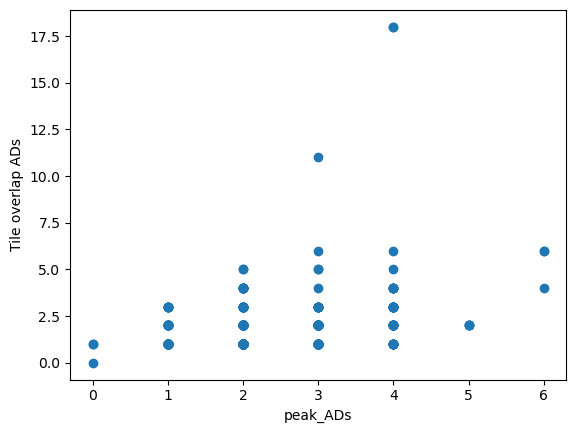

In [119]:
# Looking at relationship between peak ADs and tile overlap ADs
plt.scatter(name_key["peak_ADs"], name_key["tile_overlap_ADs"])

plt.xlabel("peak_ADs")
plt.ylabel("Tile overlap ADs")

# Putting on gene tree

In [140]:
# The gene tree has # replaced with _ for some reason
# To address this, we are changing the names in these dictionaries to match
peak_AD_dict = {}
for idx in name_key.index:
    peak_AD_dict[name_key.loc[idx, "name"].replace("#", "_")] = int(name_key.loc[idx, "peak_ADs"])

merge_AD_dict = {}
for idx in name_key.index:
    merge_AD_dict[name_key.loc[idx, "name"].replace("#", "_")] = int(name_key.loc[idx, "tile_overlap_ADs"])

In [141]:
i = 0

def mylayout(node):
    global i
    if node.is_leaf():
        name_face = AttrFace("name", fsize=60)
        node.add_face(name_face, column=0, position="aligned")

        nst = NodeStyle()
        nst["size"] = 0  # Size of the node circle, set to 0 to hide
        nst["vt_line_width"] = 10  # Vertical line thickness
        nst["hz_line_width"] = 10  # Horizontal line thickness
        nst["vt_line_color"] = "#333333"  # Vertical line color
        nst["hz_line_color"] = "#333333"  # Horizontal line color

        name = node.get_leaf_names()
        if name[0] == "Saccharomycotina_sp|P03069|GCN4_YEAST": 
            nst["bgcolor"] = "grey"
        if name[0] in peak_AD_dict.keys():
            if peak_AD_dict[name[0]] > 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="red", bgcolor="red")
                faces.add_face_to_node(face, node, column=1, aligned=True)

        
        if name[0] == "Saccharomycotina_sp|P03069|GCN4_YEAST": 
            nst["bgcolor"] = "grey"
            face = faces.RectFace(width=100, height=100, fgcolor="grey", bgcolor="grey")
            faces.add_face_to_node(face, node, column=2, aligned=True)
        else:
            face = faces.RectFace(width=100, height=100, fgcolor="white", bgcolor="white")
            faces.add_face_to_node(face, node, column=2, aligned=True)

        if name[0] in merge_AD_dict.keys():
            if merge_AD_dict[name[0]] > 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="blue", bgcolor="blue")
                faces.add_face_to_node(face, node, column=2, aligned=True)
        else:
            print(name)
        
        node.set_style(nst)
                

t = PhyloTree("../data/phylogenetic_info/gcn4_gene_phylogeny.treefile", format=1)
filtered_names = [name for name in peak_AD_dict.keys() if (t.search_nodes(name=name))] # Only including things in dataframe
t.prune(filtered_names)
ts = TreeStyle()

ts.layout_fn = mylayout
ts.mode = "c"
ts.show_leaf_name = False
# t.show(tree_style = ts)
t.render("../figures/N_terminal_AD_on_tree_merged_and_peaks.pdf", tree_style = ts)

{'nodes': [[18866.492857602338,
   19681.049483384213,
   18870.573729686814,
   19685.13035546869,
   0,
   None],
  [18876.343944030392,
   19809.91033865166,
   18881.00351478416,
   19814.569909405425,
   2,
   None],
  [20695.846526405618,
   19255.10254383506,
   20701.039293408186,
   19260.29531083763,
   4,
   None],
  [21132.70094751638,
   18642.080275109274,
   21138.268922359573,
   18647.648249952468,
   5,
   None],
  [21064.625974154238,
   17799.245114519996,
   21070.226547240163,
   17804.84568760592,
   6,
   None],
  [20243.169111993055,
   17218.686439356767,
   20247.9827846796,
   17223.50011204331,
   7,
   None],
  [18959.443559481562,
   17148.572575721042,
   18964.374409449036,
   17153.503425688516,
   8,
   None],
  [17191.562955775185,
   18325.231214374777,
   17196.985036442333,
   18330.653295041924,
   9,
   None],
  [17270.33274569555,
   21597.35259194622,
   17275.957868384638,
   21602.977714635308,
   10,
   None],
  [22081.054937500947,
   2253

In [142]:
i = 0

def mylayout(node):
    global i
    if node.is_leaf():
        name_face = AttrFace("name", fsize=60)
        node.add_face(name_face, column=0, position="aligned")

        nst = NodeStyle()
        nst["size"] = 0  # Size of the node circle, set to 0 to hide
        nst["vt_line_width"] = 10  # Vertical line thickness
        nst["hz_line_width"] = 10  # Horizontal line thickness
        nst["vt_line_color"] = "#333333"  # Vertical line color
        nst["hz_line_color"] = "#333333"  # Horizontal line color

        name = node.get_leaf_names()
        if name[0] in peak_AD_dict.keys():
            if peak_AD_dict[name[0]] == 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="red", bgcolor="red")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] == 2:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="orange", bgcolor="orange")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] == 3:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="yellow", bgcolor="yellow")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] == 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="green", bgcolor="green")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] > 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="blue", bgcolor="blue")
                faces.add_face_to_node(face, node, column=1, aligned=True)

        if name[0] == "Saccharomycotina_sp|P03069|GCN4_YEAST": 
            nst["bgcolor"] = "grey"
            face = faces.RectFace(width=100, height=100, fgcolor="grey", bgcolor="grey")
            faces.add_face_to_node(face, node, column=2, aligned=True)
        else:
            face = faces.RectFace(width=100, height=100, fgcolor="white", bgcolor="white")
            faces.add_face_to_node(face, node, column=2, aligned=True)

        if name[0] in merge_AD_dict.keys():
            if merge_AD_dict[name[0]] == 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="red", bgcolor="red")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] == 2:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="orange", bgcolor="orange")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] == 3:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="yellow", bgcolor="yellow")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] == 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="green", bgcolor="green")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] > 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="blue", bgcolor="blue")
                faces.add_face_to_node(face, node, column=3, aligned=True)
        else:
            print(name)
        
        node.set_style(nst)
                

t = PhyloTree("../data/phylogenetic_info/gcn4_gene_phylogeny.treefile", format=1)
filtered_names = [name for name in peak_AD_dict.keys() if (t.search_nodes(name=name))] # Only including things in dataframe
t.prune(filtered_names)
ts = TreeStyle()

ts.layout_fn = mylayout
ts.mode = "c"
ts.show_leaf_name = False
# t.show(tree_style = ts)

t.render("../figures/N_terminal_AD_color_count_unique_on_species_tree_merged_and_peaks.pdf", tree_style = ts)

{'nodes': [[10954.612759122248,
   11769.169384904124,
   10958.693631206726,
   11773.250256988602,
   0,
   None],
  [10964.465245949348,
   11898.029981703135,
   10969.124816703112,
   11902.6895524569,
   2,
   None],
  [12633.686003687726,
   11402.81272582624,
   12638.878770690299,
   11408.00549282881,
   4,
   None],
  [12794.18624731749,
   11027.05035394347,
   12799.754222160682,
   11032.618328786664,
   5,
   None],
  [12668.943002492728,
   10531.471300234827,
   12674.543575578655,
   10537.071873320754,
   6,
   None],
  [12124.060128207626,
   10182.448253899503,
   12128.873800894173,
   10187.26192658605,
   7,
   None],
  [11304.097575562251,
   10152.282689139152,
   11309.028425529727,
   10157.213539106628,
   8,
   None],
  [10207.102370566308,
   10915.539852143134,
   10212.524451233456,
   10920.961932810284,
   9,
   None],
  [10286.880460202128,
   12935.564031920188,
   10292.505582891217,
   12941.189154609277,
   10,
   None],
  [13171.150210077281,
  

# Putting unique gene on species tree

In [122]:
name_key_unqiue = name_key.sort_values("Length", ascending=False).drop_duplicates("Species")

In [123]:
name_key_unqiue.columns

Index(['id', 'name', 'TreeLeaf', 'Validated', 'Species', 'NCBI Taxon', 'Note',
       'AD_seq', 'full_sequence', 'SpeciesName', 'Seq', 'Length', 'WxxLF_loc',
       'SmoothedActivites', 'LinearCharge', 'LinearHydrophobicityKD',
       'SmoothedActivitesLoess', 'peak_ADs', 'tile_overlap_ADs'],
      dtype='object')

In [124]:
name_key_unqiue

,id,name,TreeLeaf,Validated,Species,NCBI Taxon,Note,AD_seq,full_sequence,SpeciesName,Seq,Length,WxxLF_loc,SmoothedActivites,LinearCharge,LinearHydrophobicityKD,SmoothedActivitesLoess,peak_ADs,tile_overlap_ADs
115,NaN,Sordariomycetes_jgi|Acral2|2047914|estExt_Gene...,Acral2,Yes,Sodiomycetes alcalophilus,NaN,NaN,NaN,NaN,Sordariomycetes_jgi|Acral2|2047914|estExt_Gene...,MADTCGGSTPLKNFSQYGSQDRSLQQDRVVHGFHGSAAAGPSTFRS...,2943,1021,"[49761.33963354764, 49761.33963354764, 49761.3...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.5444444444444445, 0.4933333333333...","[36959.46539862907, 36959.46539862907, 36959.4...",4,18
490,NaN,Pezizomycetes_jgi|Ascni1|352744|fgenesh1_pg.76...,Ascni1,Yes,Ascodesmis nigricans,NaN,NaN,NaN,NaN,Pezizomycetes_jgi|Ascni1|352744|fgenesh1_pg.76...,MSDSRHMRRPSHASDTDDEDDQSSTLHRTTSNNPYSISPSSPHRGN...,1543,1413,"[35776.33308908159, 35776.33308908159, 35776.3...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.6, 0.4, 0.4, ...","[0.0, 0.0, 0.3288888888888889, 0.2155555555555...","[31684.47651162896, 31684.47651162896, 31684.4...",3,11
55,136.0,Xylonomycetes_jgi|Trigu1|1079454|gm1.247_g,Trigu1,Yes,Trinosporium guianense,1196434.0,NaN,FRDPLASAPPSAAFTNLTSPSIFDSPDVAESFETSPLFANADHDLA...,MADALCGPSNPLQNLQKHTSVDRTLQQDRLVGPRHSPVQDFRSRSS...,Xylonomycetes_jgi|Trigu1|1079454|gm1.247_g,MADALCGPSNPLQNLQKHTSVDRTLQQDRLVGPRHSPVQDFRSRSS...,1328,1185,"[23437.5357660965, 23437.5357660965, 23437.535...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.6288888888888889, 0.6422222222222...","[29193.548646199746, 29193.548646199746, 29193...",4,4
15,137.0,Xylonomycetes_jgi|Xylhe1|264767|gm1.473_g,Xylhe1,Yes,Xylona heveae,1217826.0,NaN,LRDPLASAPPSAAFTNLTSPSIFDSPDVAESFETSPLFANADADLA...,MTDALCGPSNPLQHLQKHTSVDRTLQQDRLVGPRHSPVQDFRSQSQ...,Xylonomycetes_jgi|Xylhe1|264767|gm1.473_g,MTDALCGPSNPLQHLQKHTSVDRTLQQDRLVGPRHSPVQDFRSQSQ...,1255,1111,"[26567.768783458843, 26567.768783458843, 26567...","[0.0, 0.0, -0.2, -0.2, -0.2, 0.0, 0.0, 0.0, 0....","[0.0, 0.0, 0.5733333333333334, 0.5866666666666...","[32604.845533062748, 32604.845533062748, 32604...",4,4
384,NaN,Sordariomycetes_jgi|Daces1|522128|fgenesh1_pg....,Daces1,Yes,Dactylonectria estremocensis,NaN,NaN,NaN,NaN,Sordariomycetes_jgi|Daces1|522128|fgenesh1_pg....,MILSLTLCLTFFGLTFVIAAPEDAETLANLEVYTSLRRCAKDCFWG...,1098,970,"[58986.997709680654, 58986.997709680654, 58986...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.7933333333333333, 0.7355555555555...","[57528.193069651315, 57528.193069651315, 57528...",2,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,69.0,Mory_EHA48851.1_MagnaportheOryzae70_15,Magor1,Yes,Pyricularia oryzae,318829.0,Equivalent to magnaporthe oryzae,SDNFMSAPNSTALTTLTSPSLYNGSPDFGDSYDVSPNFVGNDLESA...,MNNTSDLGLDDFTAFGGGASAFPSPAMPGVFDIASTTASTMGTVSP...,Mory_EHA48851.1_MagnaportheOryzae70_15,MNNTSDLGLDDFTAFGGGASAFPSPAMPGVFDIASTTASTMGTVSP...,239,101,"[165405.40017749005, 165405.40017749005, 16540...","[0.0, 0.0, 0.0, -0.2, -0.2, -0.2, -0.2, -0.4, ...","[0.0, 0.0, 0.3533333333333334, 0.2333333333333...","[156903.4915015713, 156903.4915015713, 156903....",1,1
208,91.0,Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g,Hanpo2,Yes,Ogataea polymorpha,460523.0,NaN,DDHNADQALRSNPGLTISPFEIHSSVIGSIFEDPDAETAPMFEPRE...,MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...,Saccharomycotina_jgi|Hanpo2|10524|gm1.4782_g,MLLGESVFSAFAEPPSAKPVDLEDLLLDTRGSHLDDHNADQALRSN...,223,84,"[66586.92674384527, 66586.92674384527, 66586.9...","[0.0, 0.0, -0.2, -0.2, -0.2, -0.2, -0.2, 0.0, ...","[0.0, 0.0, 0.6244444444444445, 0.5644444444444...","[40285.08984708591, 40285.08984708591, 40285.0...",0,1
479,NaN,Afla_EED46972.1_AspergillusFlavusNRRL3357,Aspfl1,Yes,Aspergillus flavus,NaN,NaN,NaN,NaN,Afla_EED46972.1_AspergillusFlavusNRRL3357,MLSPHQMTAGVMAGPDSLADLPSGTISPKDLFMDASAPPSASFTDL...,216,77,"[94962.4141227763, 94962.4141227763, 94962.414...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.5022222222222221, 0.3822222222222...","[9

In [135]:
# The gene tree has # replaced with _ for some reason
# To address this, we are changing the names in these dictionaries to match
# peak_AD_dict = {}
# for idx in name_key_unqiue.index:
#     peak_AD_dict[name_key_unqiue.loc[idx, "TreeLeaf"].replace("#", "_")] = int(name_key_unqiue.loc[idx, "peak_ADs"])

# merge_AD_dict = {}
# for idx in name_key_unqiue.index:
#     merge_AD_dict[name_key_unqiue.loc[idx, "TreeLeaf"].replace("#", "_")] = int(name_key_unqiue.loc[idx, "tile_overlap_ADs"])

peak_AD_dict = {}
for idx in name_key_unqiue.index:
    peak_AD_dict[name_key_unqiue.loc[idx, "name"].replace("#", "_")] = int(name_key_unqiue.loc[idx, "peak_ADs"])

merge_AD_dict = {}
for idx in name_key_unqiue.index:
    merge_AD_dict[name_key_unqiue.loc[idx, "name"].replace("#", "_")] = int(name_key_unqiue.loc[idx, "tile_overlap_ADs"])

In [126]:
name_dict = {}
for idx in name_key_unqiue.index:
    name_dict[name_key_unqiue.loc[idx, "name"].replace("#", "_")] = name_key_unqiue.loc[idx, "Species"]

In [139]:
i = 0

def mylayout(node):
    global i
    if node.is_leaf():
        name_face = AttrFace("name", fsize=60)
        node.add_face(name_face, column=0, position="aligned")

        nst = NodeStyle()
        nst["size"] = 0  # Size of the node circle, set to 0 to hide
        nst["vt_line_width"] = 10  # Vertical line thickness
        nst["hz_line_width"] = 10  # Horizontal line thickness
        nst["vt_line_color"] = "#333333"  # Vertical line color
        nst["hz_line_color"] = "#333333"  # Horizontal line color

        name = node.get_leaf_names()
        if name[0] == "Saccharomycotina_sp|P03069|GCN4_YEAST": 
            nst["bgcolor"] = "grey"
        if name[0] in peak_AD_dict.keys():
            if peak_AD_dict[name[0]] > 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="red", bgcolor="red")
                faces.add_face_to_node(face, node, column=1, aligned=True)

        if name[0] == "Saccharomycotina_sp|P03069|GCN4_YEAST": 
            nst["bgcolor"] = "grey"
            face = faces.RectFace(width=100, height=100, fgcolor="grey", bgcolor="grey")
            faces.add_face_to_node(face, node, column=2, aligned=True)
        else:
            face = faces.RectFace(width=100, height=100, fgcolor="white", bgcolor="white")
            faces.add_face_to_node(face, node, column=2, aligned=True)

        if name[0] in merge_AD_dict.keys():
            if merge_AD_dict[name[0]] > 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="blue", bgcolor="blue")
                faces.add_face_to_node(face, node, column=3, aligned=True)
        else:
            print(name)
        
        node.set_style(nst)
        node.name = name_dict[node.name]
                

t = PhyloTree("../data/phylogenetic_info/gcn4_gene_phylogeny.treefile", format=1)
# t = PhyloTree("../data/phylogenetic_info/myco-species-tree_added.nwk", format=1)

filtered_names = [name for name in peak_AD_dict.keys() if (t.search_nodes(name=name))] # Only including things in dataframe
t.prune(filtered_names)
ts = TreeStyle()

ts.layout_fn = mylayout
ts.mode = "c"
ts.show_leaf_name = False
# t.show(tree_style = ts)
t.render("../figures/N_terminal_AD_unique_on_gene_tree_merged_and_peaks.pdf", tree_style = ts)

{'nodes': [[3650.8038598299277,
   3867.2758331195387,
   3655.2121514353116,
   3871.6841247249226,
   0,
   None],
  [4074.730282409853,
   3795.6315069437123,
   4079.4953802571586,
   3800.396604791018,
   2,
   None],
  [4139.53948911992,
   3733.5855133146815,
   4144.702646745908,
   3738.7486709406694,
   3,
   None],
  [4161.548922637721,
   3636.0792148146957,
   4167.0928376090005,
   3641.6231297859754,
   4,
   None],
  [4093.534396611929,
   3528.551044167123,
   4099.149690360932,
   3534.166337916126,
   5,
   None],
  [3920.1535202592363,
   3436.15718432428,
   3924.8021429907935,
   3440.8058070558372,
   6,
   None],
  [3569.6953694953468,
   3500.2506722240146,
   3575.3171815749142,
   3505.872484303582,
   7,
   None],
  [3434.7802426957096,
   4083.6357408059903,
   3440.2468130117545,
   4089.1023111220347,
   8,
   None],
  [4352.368169494228,
   4070.753461943847,
   4357.64763090003,
   4076.0329233496495,
   9,
   None],
  [4390.8628372466155,
   4032.95573

In [138]:
i = 0

def mylayout(node):
    global i
    if node.is_leaf():
        name_face = AttrFace("name", fsize=60)
        node.add_face(name_face, column=0, position="aligned")

        nst = NodeStyle()
        nst["size"] = 0  # Size of the node circle, set to 0 to hide
        nst["vt_line_width"] = 10  # Vertical line thickness
        nst["hz_line_width"] = 10  # Horizontal line thickness
        nst["vt_line_color"] = "#333333"  # Vertical line color
        nst["hz_line_color"] = "#333333"  # Horizontal line color

        name = node.get_leaf_names()
        if name[0] in peak_AD_dict.keys():
            if peak_AD_dict[name[0]] == 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="red", bgcolor="red")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] == 2:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="orange", bgcolor="orange")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] == 3:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="yellow", bgcolor="yellow")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] == 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="green", bgcolor="green")
                faces.add_face_to_node(face, node, column=1, aligned=True)
            elif peak_AD_dict[name[0]] > 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="blue", bgcolor="blue")
                faces.add_face_to_node(face, node, column=1, aligned=True)

        if name[0] == "Saccharomycotina_sp|P03069|GCN4_YEAST": 
            nst["bgcolor"] = "grey"
            face = faces.RectFace(width=100, height=100, fgcolor="grey", bgcolor="grey")
            faces.add_face_to_node(face, node, column=2, aligned=True)
        else:
            face = faces.RectFace(width=100, height=100, fgcolor="white", bgcolor="white")
            faces.add_face_to_node(face, node, column=2, aligned=True)

        if name[0] in merge_AD_dict.keys():
            if merge_AD_dict[name[0]] == 1:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="red", bgcolor="red")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] == 2:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="orange", bgcolor="orange")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] == 3:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="yellow", bgcolor="yellow")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] == 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="green", bgcolor="green")
                faces.add_face_to_node(face, node, column=3, aligned=True)
            elif merge_AD_dict[name[0]] > 4:
                # nst["bgcolor"] = "#75beff"
                face = faces.RectFace(width=300, height=100, fgcolor="blue", bgcolor="blue")
                faces.add_face_to_node(face, node, column=3, aligned=True)
        else:
            print(name)
        
        node.set_style(nst)
        node.name = name_dict[node.name]
                

t = PhyloTree("../data/phylogenetic_info/gcn4_gene_phylogeny.treefile", format=1)
# t = PhyloTree("../data/phylogenetic_info/myco-species-tree_added.nwk", format=1)

filtered_names = [name for name in peak_AD_dict.keys() if (t.search_nodes(name=name))] # Only including things in dataframe
t.prune(filtered_names)
ts = TreeStyle()

ts.layout_fn = mylayout
ts.mode = "c"
ts.show_leaf_name = False
# t.show(tree_style = ts)
t.render("../figures/N_terminal_AD_color_count_unique_on_gene_tree_merged_and_peaks.pdf", tree_style = ts)

{'nodes': [[3650.8038598299277,
   3867.2758331195387,
   3655.2121514353116,
   3871.6841247249226,
   0,
   None],
  [4074.730282409853,
   3795.6315069437123,
   4079.4953802571586,
   3800.396604791018,
   2,
   None],
  [4139.53948911992,
   3733.5855133146815,
   4144.702646745908,
   3738.7486709406694,
   3,
   None],
  [4161.548922637721,
   3636.0792148146957,
   4167.0928376090005,
   3641.6231297859754,
   4,
   None],
  [4093.534396611929,
   3528.551044167123,
   4099.149690360932,
   3534.166337916126,
   5,
   None],
  [3920.1535202592363,
   3436.15718432428,
   3924.8021429907935,
   3440.8058070558372,
   6,
   None],
  [3569.6953694953468,
   3500.2506722240146,
   3575.3171815749142,
   3505.872484303582,
   7,
   None],
  [3434.7802426957096,
   4083.6357408059903,
   3440.2468130117545,
   4089.1023111220347,
   8,
   None],
  [4352.368169494228,
   4070.753461943847,
   4357.64763090003,
   4076.0329233496495,
   9,
   None],
  [4390.8628372466155,
   4032.95573